# Model Performance

In [1]:
# change directory to parent folder to access all folders
import os
path = os.path.dirname(os.getcwd())
os.chdir(path)
from data_preprocessing.classes.load_traffic_data import Import_Traffic_Data

In [10]:
import pandas as pd
import numpy as np 
import plotly.graph_objects as go
from datetime import datetime
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ast
import matplotlib as mpl

##### Load Predictions

In [3]:
# Load data in 
def load_predictions(seq_len,pre_len, mean=False):
    '''Loads in CSV model prediction files.
    '''
    dir = "performance_analysis/model_predictions/"
    
    actual = pd.read_csv(dir+f"actual_{int(seq_len/12)}h_{pre_len*5}.csv",index_col=0,parse_dates=True)
    lr_pred = pd.read_csv(dir+f"lr_{int(seq_len/12)}h_{pre_len*5}.csv",index_col=0,parse_dates=True)
    lstm_pred = pd.read_csv(dir+f"lstm_{int(seq_len/12)}h_{pre_len*5}.csv",index_col=0,parse_dates=True)
    tgcn_pred = pd.read_csv(dir+f"tgcn_{int(seq_len/12)}h_{pre_len*5}.csv",index_col=0,parse_dates=True)
    tgcn_wx_pred = pd.read_csv(dir+f"tgcn-wx_{int(seq_len/12)}h_{pre_len*5}.csv",index_col=0,parse_dates=True)
    
    if mean==True:
        actual = actual.mean(axis=1)
        lr_pred = lr_pred.mean(axis=1)
        lstm_pred = lstm_pred.mean(axis=1)
        tgcn_pred = tgcn_pred.mean(axis=1)
        tgcn_wx_pred = tgcn_wx_pred.mean(axis=1)
    else:
        pass
    
    return actual,lr_pred,lstm_pred,tgcn_pred,tgcn_wx_pred

actual_1h_5min,lr_pred_1h_5min,lstm_pred_1h_5min,tgcn_pred_1h_5min,tgcn_wx_pred_1h_5min = load_predictions(12,1,mean=False)
actual_1h_15min,lr_pred_1h_15min,lstm_pred_1h_15min,tgcn_pred_1h_15min,tgcn_wx_pred_1h_15min = load_predictions(12,3,mean=False)
actual_1h_30min,lr_pred_1h_30min,lstm_pred_1h_30min,tgcn_pred_1h_30min,tgcn_wx_pred_1h_30min = load_predictions(12,6,mean=False)
actual_1h_60min,lr_pred_1h_60min,lstm_pred_1h_60min,tgcn_pred_1h_60min,tgcn_wx_pred_1h_60min = load_predictions(12,12,mean=False)

actual_6h_5min,lr_pred_6h_5min,lstm_pred_6h_5min,tgcn_pred_6h_5min,tgcn_wx_pred_6h_5min = load_predictions(12*6,1,mean=False)
actual_6h_15min,lr_pred_6h_15min,lstm_pred_6h_15min,tgcn_pred_6h_15min,tgcn_wx_pred_6h_15min = load_predictions(12*6,3,mean=False)
actual_6h_30min,lr_pred_6h_30min,lstm_pred_6h_30min,tgcn_pred_6h_30min,tgcn_wx_pred_6h_30min = load_predictions(12*6,6,mean=False)
actual_6h_60min,lr_pred_6h_60min,lstm_pred_6h_60min,tgcn_pred_6h_60min,tgcn_wx_pred_6h_60min = load_predictions(12*6,12,mean=False)



#### Load weather data

In [4]:
# load in 5min wx data from csv
wx_df = pd.read_csv("data_collection/data/wx_data/oxfordcity_wx_variables_5min_intervals.csv",index_col=0, parse_dates=True)

# collect variables of significance
wx_vars = wx_df[['precipitationIntensity','temperature','humidity','weatherCode']]

# index so wx_vars contains same length as actual speeds data
wx_vars = wx_vars.iloc[-len(actual_1h_5min):]



In [5]:
wx_vars_indexed = wx_vars.iloc[-len(actual_1h_5min):]

In [48]:
class Model_Analysis_Tools():
    '''This class of functions provides analysis tools to review the performance of the models.
    '''
    def __init__(self):
        
        # load in weather data
        # load in 5min wx data from csv
        wx_df = pd.read_csv("data_collection/data/wx_data/oxfordcity_wx_variables_5min_intervals.csv",index_col=0, parse_dates=True)

        # collect variables of significance
        self.wx_vars = wx_df[['precipitationIntensity','temperature','humidity','weatherCode']]
    
    def plot_mean_road_performance(self, title, actual_all, pred_lr_all, pred_lstm_all,pred_tgcn_all,pred_tgcn_wx_all):
        '''Plots a figure of the model performances against the actual. Must specify the seq_len & pre_len.
        '''
        
        # extract time index
        time = pred_lr_all.index
        
        # average speeds over all roads
        pred_lr = pred_lr_all.mean(axis=1)
        pred_lstm = pred_lstm_all.mean(axis=1)
        pred_tgcn = pred_tgcn_all.mean(axis=1)
        pred_tgcn_wx = pred_tgcn_wx_all.mean(axis=1)
        actual = actual_all.mean(axis=1)
        
        # plot the figure
        fig = go.Figure()

        fig.add_trace(go.Scatter(x=time, y=actual,
                            mode='lines',
                            name='Actual',line=dict(color='red', width=1.5,dash='dot')))
        fig.add_trace(go.Scatter(x=time, y=pred_lr,
                            mode='lines',
                            name='Linear Regression',line=dict(color='violet', width=1.5)))
        fig.add_trace(go.Scatter(x=time, y=pred_lstm,
                            mode='lines',
                            name='lstm',line=dict(color='violet', width=1.5)))
        fig.add_trace(go.Scatter(x=time, y=pred_tgcn,
                            mode='lines',
                            name='tgcn',line=dict(color='lightgreen', width=1.5)))
        fig.add_trace(go.Scatter(x=time, y=pred_tgcn_wx,
                            mode='lines',
                            name='tgcn-wx',line=dict(color='purple', width=1.5)))
        fig.update_layout(
            title=title,
            xaxis_title="Datetime",
            yaxis_title="Speed (km/h)",
            legend_title="Model"
        )
        fig.layout.template = 'plotly_white'
        fig.show()
        
        # print metrics of the model performances
        metrics = self.metrics(actual_all.values,pred_lr_all.values,pred_lstm_all.values,pred_tgcn_all.values,pred_tgcn_wx_all.values)
        print(metrics)


    def r2(self,true, predictions,reverse = False):
        '''Return the r2 score across the entire road network.
        '''
        if reverse ==True:
            predictions = predictions.T
            true= true.T
        r2=[]
        for road_seg in range(len(predictions)):

            # r2-score calculation using sklearn
            r2.append(r2_score(true[road_seg,:], predictions[road_seg,:]))
            
        r2 = np.array(r2)
        
        return r2
    
    def mae(self, true, predictions,reverse = False):
        '''Return the mean-absolute error across the entire road network.
        '''
        if reverse ==True:
            predictions = predictions.T
            true= true.T
            
        mae=[]
        for road_seg in range(len(predictions)):

            # mae calculation using sklearn
            mae.append(mean_absolute_error(true[road_seg,:], predictions[road_seg,:]))
            
        mae = np.array(mae)
        
        return mae
    
    def mse(self, true, predictions,reverse = False):
        '''Return the root mean squared error across the entire road network.
        '''
        if reverse ==True:
            predictions = predictions.T
            true= true.T

        mse=[]
        for road_seg in range(len(predictions)):

            #print(predictions[road_seg,:].shape)
            # rmse calculation using sklearn
            mse.append(mean_squared_error(true[road_seg,:], predictions[road_seg,:],squared=True))

        mse = np.array(mse)

        return mse  
    
    def metrics(self,true, pred_lr, pred_lstm, pred_tgcn, pred_tgcn_wx):
        '''Returns a dataframe of the model performance metrics.
        '''
        
        lr_mse = self.mse(true,pred_lr).mean()
        lr_mae = self.mae(true,pred_lr).mean()
        lr_r2 = self.r2(true,pred_lr).mean()
        
        lstm_mse =self.mse(true,pred_lstm).mean()
        lstm_mae = self.mae(true,pred_lstm).mean()
        lstm_r2 = self.r2(true,pred_lstm).mean()

        tgcn_mse = self.mse(true,pred_tgcn).mean()
        tgcn_mae = self.mae(true,pred_tgcn).mean()
        tgcn_r2 = self.r2(true,pred_tgcn).mean()

        tgcn_wx_mse = self.mse(true,pred_tgcn_wx).mean()
        tgcn_wx_mae = self.mae(true,pred_tgcn_wx).mean()
        tgcn_wx_r2 = self.r2(true,pred_tgcn_wx).mean()

        metrics_df = pd.DataFrame({"Linear Regression":[lr_mse,lr_mae,lr_r2],
                                  "LSTM":[lstm_mse, lstm_mae,lstm_r2],
                                  "T-GCN":[tgcn_mse,tgcn_mae,tgcn_r2],
                                  "T-GCN-WX":[tgcn_wx_mse,tgcn_wx_mae,tgcn_wx_r2]},index=["mse","mae","r2"])

        return metrics_df
    
    def filter_weekend(self,actual,lr,lstm,tgcn,tgcn_wx):
        
        filter_actual = actual[(actual.index.day_name() == "Friday")|(actual.index.day_name() =="Saturday")|(actual.index.day_name() =="Sunday")]
        filter_lr = lr[(lr.index.day_name() == "Friday")|(lr.index.day_name() =="Saturday")|(lr.index.day_name() =="Sunday")]
        filter_lstm = lstm[(lstm.index.day_name() == "Friday")|(lstm.index.day_name() =="Saturday")|(lstm.index.day_name() =="Sunday")]
        filter_tgcn = tgcn[(tgcn.index.day_name() == "Friday")|(tgcn.index.day_name() =="Saturday")|(tgcn.index.day_name() =="Sunday")]
        filter_tgcn_wx = tgcn_wx[(tgcn_wx.index.day_name() == "Friday")|(tgcn_wx.index.day_name() =="Saturday")|(tgcn_wx.index.day_name() =="Sunday")]

        return filter_actual,filter_lr,filter_lstm,filter_tgcn,filter_tgcn_wx
    
    def filter_weekday(self,actual,lr,lstm,tgcn,tgcn_wx):
        filter_actual = actual[(actual.index.day_name() == "Monday")|(actual.index.day_name() =="Tuesday")|(actual.index.day_name() =="Wednesday")]
        filter_lr = lr[(lr.index.day_name() == "Monday")|(lr.index.day_name() =="Tuesday")|(lr.index.day_name() =="Wednesday")]
        filter_lstm = lstm[(lstm.index.day_name() == "Monday")|(lstm.index.day_name() =="Tuesday")|(lstm.index.day_name() =="Wednesday")]
        filter_tgcn = tgcn[(tgcn.index.day_name() == "Monday")|(tgcn.index.day_name() =="Tuesday")|(tgcn.index.day_name() =="Wednesday")]
        filter_tgcn_wx = tgcn_wx[(tgcn_wx.index.day_name() == "Monday")|(tgcn_wx.index.day_name() =="Tuesday")|(tgcn_wx.index.day_name() =="Wednesday")]

        return filter_actual,filter_lr,filter_lstm,filter_tgcn,filter_tgcn_wx
    
    def filter_precip(self,actual,lr,lstm,tgcn,tgcn_wx):
        wx_vars_indexed = self.wx_vars.iloc[-len(actual):]

        # filter for precip
        actual_precip = actual[wx_vars_indexed["precipitationIntensity"]>1]
        lr_precip = lr[wx_vars_indexed["precipitationIntensity"]>1]
        lstm_precip = lstm[wx_vars_indexed["precipitationIntensity"]>1]
        tgcn_precip = tgcn[wx_vars_indexed["precipitationIntensity"]>1]
        tgcn_wx_precip = tgcn_wx[wx_vars_indexed["precipitationIntensity"]>1]
        
        # and filter for no precip
        actual_noprecip = actual[wx_vars_indexed["precipitationIntensity"]<=1]
        lr_noprecip = lr[wx_vars_indexed["precipitationIntensity"]<=1]
        lstm_noprecip = lstm[wx_vars_indexed["precipitationIntensity"]<=1]
        tgcn_noprecip = tgcn[wx_vars_indexed["precipitationIntensity"]<=1]
        tgcn_wx_noprecip = tgcn_wx[wx_vars_indexed["precipitationIntensity"]<=1]
        
        # collect the metrics on precip and no precip
        
        precip_metrics = self.metrics(actual_precip.values,lr_precip.values,lstm_precip.values,tgcn_precip.values,tgcn_wx_precip.values)
        noprecip_metrics = self.metrics(actual_noprecip.values,lr_noprecip.values,lstm_noprecip.values,tgcn_noprecip.values,tgcn_wx_noprecip.values)

        results = pd.concat([precip_metrics.T.rmse,noprecip_metrics.T.rmse],axis=1)
        results.columns = ["precip_obs","no_precip_obs"]
        
        return results.plot.bar(ylabel="rmse",title="Precipitation Impact on Models: 5min Predictions")
        
    def _return_metrics(self,true, pred_lr, pred_lstm, pred_tgcn, pred_tgcn_wx):
        
        index = true.index
        true = true.values
        
        
        lr_mse = pd.DataFrame(self.mse(true,pred_lr),index=index)
        lr_mae = pd.DataFrame(self.mae(true,pred_lr),index=index)
        lr_r2 = pd.DataFrame(self.r2(true,pred_lr),index=index)
        
        lstm_mse =pd.DataFrame(self.mse(true,pred_lstm),index=index)
        lstm_mae = pd.DataFrame(self.mae(true,pred_lstm),index=index)
        lstm_r2 = pd.DataFrame(self.r2(true,pred_lstm),index=index)

        tgcn_mse = pd.DataFrame(self.mse(true,pred_tgcn),index=index)
        tgcn_mae = pd.DataFrame(self.mae(true,pred_tgcn),index=index)
        tgcn_r2 = pd.DataFrame(self.r2(true,pred_tgcn),index=index)

        tgcn_wx_mse = pd.DataFrame(self.mse(true,pred_tgcn_wx),index=index)
        tgcn_wx_mae = pd.DataFrame(self.mae(true,pred_tgcn_wx),index=index)
        tgcn_wx_r2 = pd.DataFrame(self.r2(true,pred_tgcn_wx),index=index)
        
        return lr_mse,lr_mae,lr_r2,lstm_mse,lstm_mae,lstm_r2,tgcn_mse,tgcn_mae,tgcn_r2,tgcn_wx_mse,tgcn_wx_mae,tgcn_wx_r2
    
    def geoplot_metric(self, machine_learning_method, metric,lats,lons, method="MSE"):
        '''This function creates a geoplot of the Peartree roundabout mean-squared error by road segment.
        '''

        


        # generate color scheme for mse
        colors = ["maroon","darkred","red","orangered","peru","orange","gold","yellow","green","lightgreen","greenyellow"]

        # if metric is MSE/MAE reverse the color order 
        if (method == "MSE") | (method=="MAE"):
            colors = colors[::-1]
        else:
            pass


        # create linearly spaced intervals for 10 colors
        color_vals = np.linspace(metric.min(),metric.max(),10)
        color_vals = np.linspace(0.00129,0.01287,10)
        
        # Create geographic plot of road network 
        fig, ax = plt.subplots(figsize=(7, 7))
        plt.grid(False)
        for i in range(0,len(metric)):
            plt.xlim(-1.281979,-1.289524)

            # values
            color_val= metric[i]
            if color_val <color_vals[0]:
                color = colors[0]
            elif (color_val >=color_vals[0]) & (color_val <color_vals[1]):
                color = colors[1]
            elif (color_val >=color_vals[1]) & (color_val <color_vals[2]):
                color = colors[2]
            elif (color_val >=color_vals[2]) & (color_val <color_vals[3]):
                color = colors[3]
            elif (color_val >=color_vals[3]) & (color_val <color_vals[4]):
                color = colors[4]
            elif (color_val >=color_vals[4]) & (color_val <color_vals[5]):
                color = colors[5]
            elif (color_val >=color_vals[5]) & (color_val <color_vals[6]):
                color = colors[6]
            elif (color_val >=color_vals[6]) & (color_val <color_vals[7]):
                color = colors[7]
            elif (color_val >=color_vals[7]) & (color_val <color_vals[8]):
                color = colors[8]
            elif (color_val >=color_vals[8]) & (color_val <color_vals[9]):
                color = colors[9]
            else:
                color = colors[10]

            plt.plot(ast.literal_eval(lons[i]),ast.literal_eval(lats[i]), c=color,linewidth=4)

        plt.axis('off')
        plt.title(f"{machine_learning_method}: Peartree Roundabout {method}")
        plt.gca().invert_xaxis()
        plt.style.use('dark_background')
        plt.style.use('dark_background')
        plt.show()

        # COLORBAR

        fig, ax = plt.subplots(figsize=(10, 1))
        fig.subplots_adjust(bottom=0.5)
        cmap = mpl.colors.ListedColormap(colors)
        bounds = color_vals
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cb3 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                        norm=norm,
                                        extend='both',
                                        extendfrac='auto',
                                        ticks=bounds,
                                        spacing='uniform',
                                        orientation='horizontal')
        cb3.set_label(method)
        fig.show()
        
           


In [49]:
# Create CSV of metrics 

def metrics_to_csv():
    '''Converts model metrics to CSV files.
    '''
    lr_5min_mse,lr_5min_mae,lr_5min_r2,lstm_5min_mse,lstm_5min_mae,lstm_5min_r2,tgcn_5min_mse,tgcn_5min_mae,tgcn_5min_r2,tgcn_wx_5min_mse,tgcn_wx_5min_mae,tgcn_wx_5min_r2 = a._return_metrics(actual_1h_5min,lr_pred_1h_5min.values,lstm_pred_1h_5min.values,tgcn_pred_1h_5min.values,tgcn_wx_pred_1h_5min.values)
    lr_15min_mse,lr_15min_mae,lr_15min_r2,lstm_15min_mse,lstm_15min_mae,lstm_15min_r2,tgcn_15min_mse,tgcn_15min_mae,tgcn_15min_r2,tgcn_wx_15min_mse,tgcn_wx_15min_mae,tgcn_wx_15min_r2 = a._return_metrics(actual_1h_15min,lr_pred_1h_15min.values,lstm_pred_1h_15min.values,tgcn_pred_1h_15min.values,tgcn_wx_pred_1h_15min.values)
    lr_30min_mse,lr_30min_mae,lr_30min_r2,lstm_30min_mse,lstm_30min_mae,lstm_30min_r2,tgcn_30min_mse,tgcn_30min_mae,tgcn_30min_r2,tgcn_wx_30min_mse,tgcn_wx_30min_mae,tgcn_wx_30min_r2 = a._return_metrics(actual_1h_30min,lr_pred_1h_30min.values,lstm_pred_1h_30min.values,tgcn_pred_1h_30min.values,tgcn_wx_pred_1h_30min.values)
    lr_60min_mse,lr_60min_mae,lr_60min_r2,lstm_60min_mse,lstm_60min_mae,lstm_60min_r2,tgcn_60min_mse,tgcn_60min_mae,tgcn_60min_r2,tgcn_wx_60min_mse,tgcn_wx_60min_mae,tgcn_wx_60min_r2 = a._return_metrics(actual_1h_60min,lr_pred_1h_60min.values,lstm_pred_1h_60min.values,tgcn_pred_1h_60min.values,tgcn_wx_pred_1h_60min.values)
    
    mse_df = pd.concat([lr_5min_mse,lstm_5min_mse,tgcn_5min_mse,tgcn_wx_5min_mse,lr_15min_mse,lstm_15min_mse,tgcn_15min_mse,tgcn_wx_15min_mse,lr_30min_mse,lstm_30min_mse,tgcn_30min_mse,tgcn_wx_30min_mse,lr_60min_mse,lstm_60min_mse,tgcn_60min_mse,tgcn_wx_60min_mse],axis=1)
    mae_df = pd.concat([lr_5min_mae,lstm_5min_mae,tgcn_5min_mae,tgcn_wx_5min_mae,lr_15min_mae,lstm_15min_mae,tgcn_15min_mae,tgcn_wx_15min_mae,lr_30min_mae,lstm_30min_mae,tgcn_30min_mae,tgcn_wx_30min_mae,lr_60min_mae,lstm_60min_mae,tgcn_60min_mae,tgcn_wx_60min_mae],axis=1)
    r2_df = pd.concat([lr_5min_r2,lstm_5min_r2,tgcn_5min_r2,tgcn_wx_5min_r2,lr_15min_r2,lstm_15min_r2,tgcn_15min_r2,tgcn_wx_15min_r2,lr_30min_r2,lstm_30min_r2,tgcn_30min_r2,tgcn_wx_30min_r2,lr_60min_r2,lstm_60min_r2,tgcn_60min_r2,tgcn_wx_60min_r2],axis=1)
    
    col_names = ["lr_5min","lstm_5min","tgcn_5min","tgcn_wx_5min","lr_15min","lstm_15min","tgcn_15min","tgcn_wx_15min","lr_30min","lstm_30min","tgcn_30min","tgcn_wx_30min","lr_60min","lstm_60min","tgcn_60min","tgcn_wx_60min"]
    
    mse_df.columns = col_names
    mae_df.columns = col_names
    r2_df.columns = col_names
    
    return mse_df,mae_df,r2_df

In [50]:
# Convert MSE,MAE,R2 to CSV files
a = Model_Analysis_Tools()
mse_df,mae_df,r2_df = metrics_to_csv()
mse_df.to_csv("performance_analysis/mse_metrics.csv")
mae_df.to_csv("performance_analysis/mae_metrics.csv")
r2_df.to_csv("performance_analysis/r2_metrics.csv")

In [54]:
a = Model_Analysis_Tools()
title="Model Comparisons using 1-Hour Inputs to Predict 5-min"
a.plot_mean_road_performance(title,actual_1h_5min,lr_pred_1h_5min,lstm_pred_1h_5min,tgcn_pred_1h_5min,tgcn_wx_pred_1h_5min)


     Linear Regression      LSTM     T-GCN  T-GCN-WX
mse           0.002833  0.003039  0.002800  0.002925
mae           0.033238  0.036510  0.035728  0.035184
r2            0.914717  0.908529  0.916736  0.912368
acc           0.023875  0.023873  0.021219  0.020785


In [47]:
model = ["lr","lstm","tgcn","tgcn-wx","lr","lstm","tgcn","tgcn-wx","lr","lstm","tgcn","tgcn-wx","lr","lstm","tgcn","tgcn-wx"]
pre_len = [5,5,5,5,15,15,15,15,30,30,30,30,60,60,60,60]
mse = mse_df.mean()
mae = mae_df.mean()
r2 = r2_df.mean()


model_overall_perf = pd.DataFrame({"model":model,"pre_len":pre_len,"mse":mse,"mae":mae,"r2":r2})
model_overall_perf.to_csv("performance_analysis/model_performance_metrics.csv")

# Overall Performances

In [262]:
# RMSE by all models averaged 
mse_df = pd.read_csv("performance_analysis/mse_metrics.csv",index_col=0,parse_dates=True)



# Weather Influence

In [259]:
# concat weather variables
model_overall_perf_wx = pd.concat([model_overall_perf,wx_vars],axis=1)

# replace weather codes with actual strings
weather_codes = {1000:"Sunny",1100:"Mostly Sunny",1101:"Partly Cloudy",1102:"Mostly Cloudy",
                1001:"Cloudy",4000:"Drizzle",4001:"Rain",4200:"Light Rain"}

model_overall_perf_wx = model_overall_perf_wx.replace({"weatherCode":weather_codes}) 
model_overall_perf_wx.to_csv("model_overall_performance_metrics_wx.csv")

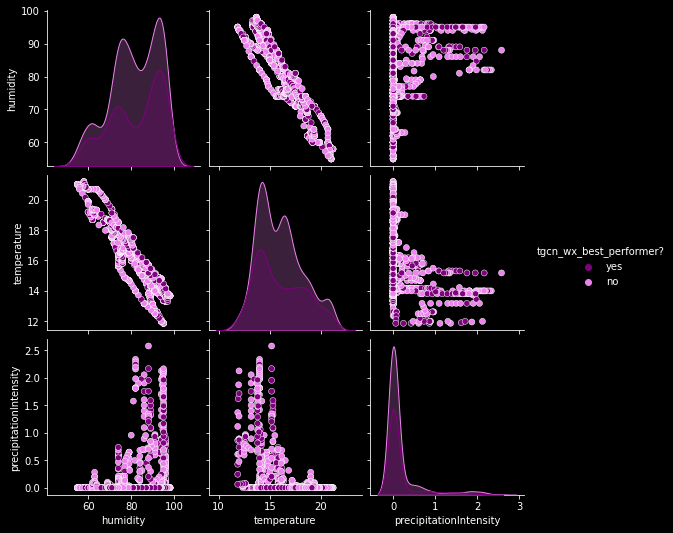

In [666]:
# select times when T-GCN-WX model performed best
tgcn_wx_best = np.where((model_overall_perf_wx.tgcn_wx_mse<model_overall_perf_wx.tgcn_mse) & (model_overall_perf_wx.tgcn_wx_mse<model_overall_perf_wx.lr_mse),"yes","no")
model_overall_perf_wx['tgcn_wx_best_performer?']= tgcn_wx_best

# create a pairplot to view if there are any wx variables attributing to the TGCN-wx performing better
pplot = sns.pairplot(model_overall_perf_wx.iloc[:,[-1,-2,-3,-4,-5]],hue="tgcn_wx_best_performer?",palette=sns.color_palette(["purple","violet"]))
#pplot.savefig("performance_analysis/pplot.png")


No evidence of the T-GCN wx model outperforming the other three models based on weather variables alone. 

## T-GCN-wx Predictions vs Actual

In [370]:
# create dataframe of t-gcn-wx mean predictions and the actual mean predictions.
tgcn_wx_mean_pred = pd.concat([tgcn_wx_pred_1h_5min.mean(axis=1),tgcn_wx_pred_1h_15min.mean(axis=1),tgcn_wx_pred_1h_30min.mean(axis=1),tgcn_wx_pred_1h_60min.mean(axis=1)],axis=1)
tgcn_wx_mean_pred = pd.concat([actual_1h_5min.mean(axis=1),tgcn_wx_mean_pred],axis=1)
tgcn_wx_mean_pred.columns = ["actual","5-min","15-min","30-min","60-min"]

# Rescale the speeds
tgcn_wx_mean_pred = tgcn_wx_mean_pred*113


Text(0.5, 0.98, 'T-GCN-wx Predicted vs Actual')

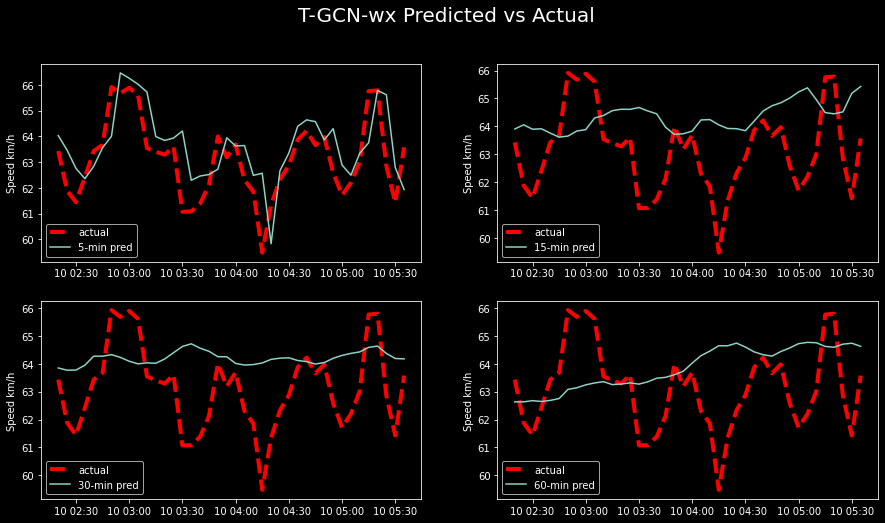

In [665]:
start_ind = 200
end_ind = 240


fig, axs = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(15)

axs[0, 0].plot(tgcn_wx_mean_pred.actual.iloc[start_ind:end_ind],'r--',label="actual",linewidth=4)
axs[0, 0].plot(tgcn_wx_mean_pred["5-min"].iloc[start_ind:end_ind],label="5-min pred")
axs[0, 0].set_ylabel("Speed km/h")

axs[0, 1].plot(tgcn_wx_mean_pred.actual.iloc[start_ind:end_ind],'r--',label="actual",linewidth=4)
axs[0, 1].plot(tgcn_wx_mean_pred["15-min"].iloc[start_ind:end_ind],label="15-min pred")
axs[0, 1].set_ylabel("Speed km/h")

axs[1, 0].plot(tgcn_wx_mean_pred.actual.iloc[start_ind:end_ind],'r--',label="actual",linewidth=4)
axs[1, 0].plot(tgcn_wx_mean_pred["30-min"].iloc[start_ind:end_ind],label="30-min pred")
axs[1, 0].set_ylabel("Speed km/h")

axs[1, 1].plot(tgcn_wx_mean_pred.actual.iloc[start_ind:end_ind],'r--',label="actual",linewidth=4)
axs[1, 1].plot(tgcn_wx_mean_pred["60-min"].iloc[start_ind:end_ind],label="60-min pred")
axs[1, 1].set_ylabel("Speed km/h")

axs[0, 0].legend()
axs[1, 0].legend()
axs[1, 1].legend()
axs[0, 1].legend()

fig.suptitle("T-GCN-wx Predicted vs Actual",fontsize=20)



## Spatial Analysis

In [465]:
# Peartree roundabout bbox and datetimes of interest
top=51.798433
bottom=51.791451
right=-1.281979
left=-1.289524
datetime_start=datetime(2021,6,23,0,0)
datetime_end=datetime(2021,6,23,0,5)

# load in traffic data
traffic_data,time = Import_Traffic_Data(top,bottom,right,left).load_traffic_data(datetime_start,datetime_end)

# coordinates
lons = traffic_data[0,:,4]
lats = traffic_data[0,:,3]

In [583]:
spatial_mse_lr_5min = a.mse(actual_1h_5min.values,lr_pred_1h_5min.values,reverse=True)
spatial_mse_lr_15min = a.mse(actual_1h_15min.values,lr_pred_1h_15min.values,reverse=True)
spatial_mse_lr_30min = a.mse(actual_1h_30min.values,lr_pred_1h_30min.values,reverse=True)
spatial_mse_lr_60min = a.mse(actual_1h_60min.values,lr_pred_1h_60min.values,reverse=True)
spatial_mse_lr = np.mean([spatial_mse_lr_5min,spatial_mse_lr_15min,spatial_mse_lr_30min,spatial_mse_lr_60min],axis=0)

spatial_mse_lstm_5min = a.mse(actual_1h_5min.values,lstm_pred_1h_5min.values,reverse=True)
spatial_mse_lstm_15min = a.mse(actual_1h_15min.values,lstm_pred_1h_15min.values,reverse=True)
spatial_mse_lstm_30min = a.mse(actual_1h_30min.values,lstm_pred_1h_30min.values,reverse=True)
spatial_mse_lstm_60min = a.mse(actual_1h_60min.values,lstm_pred_1h_60min.values,reverse=True)
spatial_mse_lstm = np.mean([spatial_mse_lstm_5min,spatial_mse_lstm_15min,spatial_mse_lstm_30min,spatial_mse_lstm_60min],axis=0)

spatial_mse_tgcn_5min = a.mse(actual_1h_5min.values,tgcn_pred_1h_5min.values,reverse=True)
spatial_mse_tgcn_15min = a.mse(actual_1h_15min.values,tgcn_pred_1h_15min.values,reverse=True)
spatial_mse_tgcn_30min = a.mse(actual_1h_30min.values,tgcn_pred_1h_30min.values,reverse=True)
spatial_mse_tgcn_60min = a.mse(actual_1h_60min.values,tgcn_pred_1h_60min.values,reverse=True)
spatial_mse_tgcn = np.mean([spatial_mse_tgcn_5min,spatial_mse_tgcn_15min,spatial_mse_tgcn_30min,spatial_mse_tgcn_60min],axis=0)

spatial_mse_tgcn_wx_5min = a.mse(actual_1h_5min.values,tgcn_wx_pred_1h_5min.values,reverse=True)
spatial_mse_tgcn_wx_15min = a.mse(actual_1h_15min.values,tgcn_wx_pred_1h_15min.values,reverse=True)
spatial_mse_tgcn_wx_30min = a.mse(actual_1h_30min.values,tgcn_wx_pred_1h_30min.values,reverse=True)
spatial_mse_tgcn_wx_60min = a.mse(actual_1h_60min.values,tgcn_wx_pred_1h_60min.values,reverse=True)
spatial_mse_tgcn_wx = np.mean([spatial_mse_tgcn_wx_5min,spatial_mse_tgcn_wx_15min,spatial_mse_tgcn_wx_30min,spatial_mse_tgcn_wx_60min],axis=0)


In [610]:
print(spatial_mse_tgcn.mean())
print(spatial_mse_lr.mean())

0.004355519840786752
0.004559926745434596


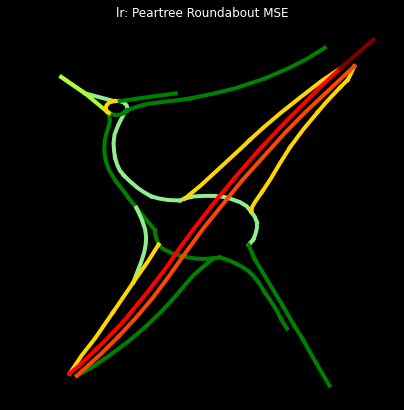

<ipython-input-596-9e9dbf26343a>:283: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



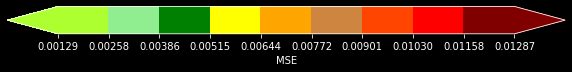

In [599]:
a.geoplot_metric("lr",metric=spatial_mse_lr,lats=lats,lons=lons)


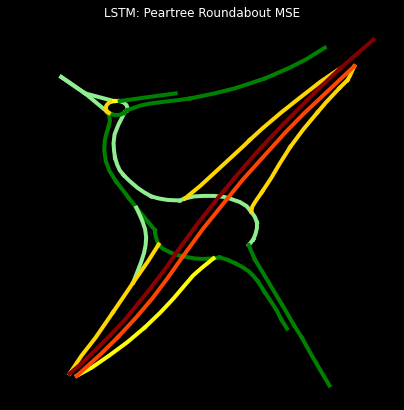

<ipython-input-596-9e9dbf26343a>:283: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



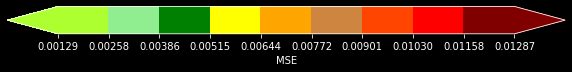

In [600]:
a.geoplot_metric("LSTM",metric=spatial_mse_lstm,lats=lats,lons=lons)

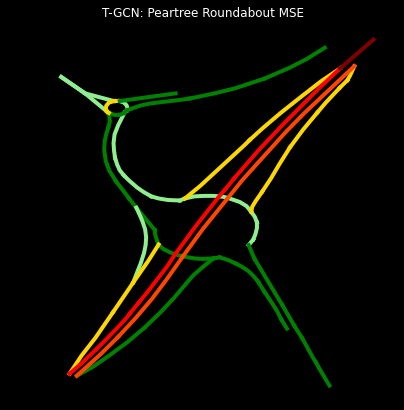

<ipython-input-596-9e9dbf26343a>:283: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



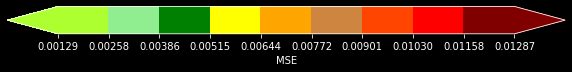

In [601]:
a.geoplot_metric("T-GCN",metric=spatial_mse_tgcn,lats=lats,lons=lons)

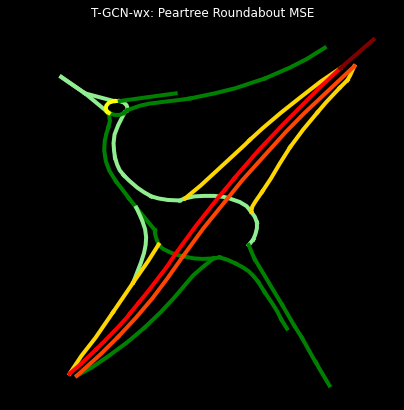

<ipython-input-596-9e9dbf26343a>:283: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



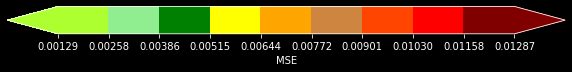

In [602]:
a.geoplot_metric("T-GCN-wx",metric=spatial_mse_tgcn_wx,lats=lats,lons=lons)

In [634]:
print("Linear Regression Spatial MSE: ",spatial_mse_lr.mean())
print("LSTM Spatial MSE: ",spatial_mse_lstm.mean())
print("T-GCN Spatial MSE: ",spatial_mse_tgcn.mean())
print("T-GCN-wx Spatial MSE: ",spatial_mse_tgcn_wx.mean())

Linear Regression Spatial MSE:  0.004559926745434596
LSTM Spatial MSE:  0.00459480763736252
T-GCN Spatial MSE:  0.004355519840786752
T-GCN-wx Spatial MSE:  0.004401795114694697


## Statistical Significance

In [621]:
# t-tests to see spatial difference
import statsmodels.api as sm

print("Statistical Difference between spatial MSE")
print("p-value: ",sm.stats.ttest_ind(spatial_mse_tgcn, spatial_mse_lstm)[1])

Statistical Difference between spatial MSE
p-value:  0.6571689461777893


All of the model performances for MSE are statistically similair. Suggesting all models are the same. 

In [660]:
metric = mse_df
for i in range(len(metric.iloc[0])):
    for j in range(len(metric.iloc[0])):
        res = sm.stats.ttest_ind(metric.iloc[:,i].dropna(), metric.iloc[:,j].dropna())
        if (res[1] < 0.05) & (metric.iloc[:,i].name.find("tgcn_wx")==0):
            print(metric.iloc[:,i].name,metric.iloc[:,j].name,"Significant")
        else:
            pass


tgcn_wx_5min lr_15min Significant
tgcn_wx_5min lstm_15min Significant
tgcn_wx_5min tgcn_15min Significant
tgcn_wx_5min tgcn_wx_15min Significant
tgcn_wx_5min lr_30min Significant
tgcn_wx_5min lstm_30min Significant
tgcn_wx_5min tgcn_30min Significant
tgcn_wx_5min tgcn_wx_30min Significant
tgcn_wx_5min lr_60min Significant
tgcn_wx_5min lstm_60min Significant
tgcn_wx_5min tgcn_60min Significant
tgcn_wx_5min tgcn_wx_60min Significant
tgcn_wx_15min lr_5min Significant
tgcn_wx_15min lstm_5min Significant
tgcn_wx_15min tgcn_5min Significant
tgcn_wx_15min tgcn_wx_5min Significant
tgcn_wx_15min lr_30min Significant
tgcn_wx_15min lstm_30min Significant
tgcn_wx_15min lr_60min Significant
tgcn_wx_15min lstm_60min Significant
tgcn_wx_15min tgcn_60min Significant
tgcn_wx_15min tgcn_wx_60min Significant
tgcn_wx_30min lr_5min Significant
tgcn_wx_30min lstm_5min Significant
tgcn_wx_30min tgcn_5min Significant
tgcn_wx_30min tgcn_wx_5min Significant
tgcn_wx_30min lr_60min Significant
tgcn_wx_30min lstm_

None of the models from the same prediction lengths have significantly different performances for MSE.

In [661]:
metric = mae_df
for i in range(len(metric.iloc[0])):
    for j in range(len(metric.iloc[0])):
        res = sm.stats.ttest_ind(metric.iloc[:,i].dropna(), metric.iloc[:,j].dropna())
        if (res[1] < 0.05) & (metric.iloc[:,i].name.find("tgcn_wx")==0):
            print(metric.iloc[:,i].name,metric.iloc[:,j].name,"Significant")
        else:
            pass

tgcn_wx_5min lr_5min Significant
tgcn_wx_5min lstm_5min Significant
tgcn_wx_5min lr_15min Significant
tgcn_wx_5min lstm_15min Significant
tgcn_wx_5min tgcn_15min Significant
tgcn_wx_5min tgcn_wx_15min Significant
tgcn_wx_5min lr_30min Significant
tgcn_wx_5min lstm_30min Significant
tgcn_wx_5min tgcn_30min Significant
tgcn_wx_5min tgcn_wx_30min Significant
tgcn_wx_5min lr_60min Significant
tgcn_wx_5min lstm_60min Significant
tgcn_wx_5min tgcn_60min Significant
tgcn_wx_5min tgcn_wx_60min Significant
tgcn_wx_15min lr_5min Significant
tgcn_wx_15min lstm_5min Significant
tgcn_wx_15min tgcn_5min Significant
tgcn_wx_15min tgcn_wx_5min Significant
tgcn_wx_15min lr_30min Significant
tgcn_wx_15min lstm_30min Significant
tgcn_wx_15min lr_60min Significant
tgcn_wx_15min lstm_60min Significant
tgcn_wx_15min tgcn_60min Significant
tgcn_wx_15min tgcn_wx_60min Significant
tgcn_wx_30min lr_5min Significant
tgcn_wx_30min lstm_5min Significant
tgcn_wx_30min tgcn_5min Significant
tgcn_wx_30min tgcn_wx_5mi

In [663]:
metric = r2_df
for i in range(len(metric.iloc[0])):
    for j in range(len(metric.iloc[0])):
        res = sm.stats.ttest_ind(metric.iloc[:,i].dropna(), metric.iloc[:,j].dropna())
        if (res[1] < 0.05) & (metric.iloc[:,i].name.find("tgcn_wx")==0):
            print(metric.iloc[:,i].name,metric.iloc[:,j].name,"Significant")
        else:
            pass

tgcn_wx_5min lr_15min Significant
tgcn_wx_5min lstm_15min Significant
tgcn_wx_5min tgcn_15min Significant
tgcn_wx_5min tgcn_wx_15min Significant
tgcn_wx_5min lr_30min Significant
tgcn_wx_5min lstm_30min Significant
tgcn_wx_5min tgcn_30min Significant
tgcn_wx_5min tgcn_wx_30min Significant
tgcn_wx_5min lr_60min Significant
tgcn_wx_5min lstm_60min Significant
tgcn_wx_5min tgcn_60min Significant
tgcn_wx_5min tgcn_wx_60min Significant
tgcn_wx_15min lr_5min Significant
tgcn_wx_15min lstm_5min Significant
tgcn_wx_15min tgcn_5min Significant
tgcn_wx_15min tgcn_wx_5min Significant
tgcn_wx_15min lr_30min Significant
tgcn_wx_15min lstm_30min Significant
tgcn_wx_15min lr_60min Significant
tgcn_wx_15min lstm_60min Significant
tgcn_wx_15min tgcn_60min Significant
tgcn_wx_15min tgcn_wx_60min Significant
tgcn_wx_30min lr_5min Significant
tgcn_wx_30min lstm_5min Significant
tgcn_wx_30min tgcn_5min Significant
tgcn_wx_30min tgcn_wx_5min Significant
tgcn_wx_30min lr_60min Significant
tgcn_wx_30min lstm_

For R2 no significant differences.